In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

import cv2
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image as Im

from image.image import Image
from control.control import Control
from utils import utils

%matplotlib inline

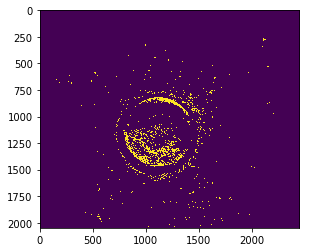

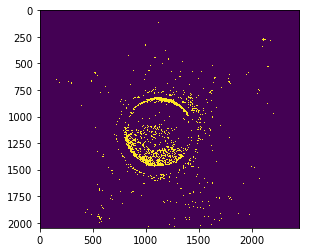

In [2]:
# This currently works by importing from the code base, to make it work with the code bellow
# move this cell all the way to the bottom and rerun all cells by click Kernel at the top then
# selecting 'Restart and Run All'

# Create a control for the images and there assocaited data to be
# stored in
c = Control('abrasion014_abraded.JPG', 
            'abrasion014_after1.JPG',
            basepath = '/Users/adampaquette/notebooks/Abrasion Images/')

# Add a second image pair
c.add_image_pair('abrasion014_abraded.JPG', 
                 'abrasion014_after2.JPG',
                 basepath = '/Users/adampaquette/notebooks/Abrasion Images/')

# Apply normalization to each image pair
c.apply_func(utils.normalize_func)

# Apply the subtract function to each pair and generate a subtraction mask
c.apply_func(utils.subtract_func)

# Display the masks
plt.figure(0)
plt.imshow(c.dataframe.after_image.loc[0].sub_mask)

plt.figure(1)
plt.imshow(c.dataframe.after_image.loc[1].sub_mask)

In [3]:
def normalize(image, newMin, newMax):
    image = ((image - image.min()) * ((newMax - newMin)/(image.max() - image.min()))) + newMin
    return image

In [4]:
class Image:
    
    def __init__(self, basepath, image, readType = 0):
        self.image_data = {}
        self.image_name = image
        self.image_data['orig_image_data'] = cv2.imread(basepath + image, readType)
    
    def __getitem__(self, index):
        return self.image_data[index]
    
    def normalize_image(self, newMin = 0, newMax = 1):
        self.image_data['norm_image_data'] = normalize(self.image_data['orig_image_data'], 0, 1)
    
    def xy_extent(self):
        return (len(self.image_data['orig_image_data']),
                len(self.image_data['orig_image_data'][0]))

In [5]:
class Control:
    
    def __init__(self, before_image, after_image, basepath, *args, **kwargs):
        # Loads a list of images and their associated pairs
        self.dataframe = pd.DataFrame(data = {'image_group': before_image,
                                              'before_image': [Image(basepath, before_image, *args, **kwargs)], 
                                              'after_image':  [Image(basepath, after_image, *args, **kwargs)], 
                                              'output_image': [None]})
        
    def add_image_pair(self, before_image, after_image, basepath, *args, **kwargs):
        new_pair = pd.DataFrame(data = {'image_group': before_image,
                                        'before_image': [Image(basepath, before_image, *args, **kwargs)], 
                                        'after_image':  [Image(basepath, after_image, *args, **kwargs)], 
                                        'output_image': [None]})
        self.dataframe = pd.concat([self.dataframe, new_pair], ignore_index=True)
     
    def apply_func(self, func, *args, **kwargs):
        self.dataframe.apply(func, axis = 1, *args, **kwargs)

In [6]:
def subtract_func(row, varThresh = .055, varInit = .3, varMix = 0, varMax = 1, useNorm = True):
    if useNorm:
        try:
            img1 = row['before_image']['norm_image_data']
            img2 = row['after_image']['norm_image_data']
        except KeyError:
            raise KeyError('Images do not have their associated normalized images.')
    else:
        img1 = row['before_image']['orig_image_data']
        img2 = row['after_image']['orig_image_data']

    fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows = False)
    fgbg.setVarThreshold(.055)
    fgbg.setVarInit(.3)
    fgbg.setVarMax(1)
    fgbg.setVarMin(0)
    fgbg.apply(img2)
    img_mask = fgbg.apply(img1)
    row['before_image'].sub_mask = img_mask
    row['after_image'].sub_mask = img_mask
    
def normalize_func(row, newMin = 0, newMax = 1):
    row['before_image'].normalize_image(newMin = newMin, newMax = newMax)
    row['after_image'].normalize_image(newMin = newMin, newMax = newMax)
    
def hist_estimation(row, *args, **kwargs):
    print(row)